


Epoch 1/5

2500/2500 [==============================] - 59s 23ms/step - loss: 0.9716 - val_loss: 1.1155
Epoch 2/5
2500/2500 [==============================] - 57s 23ms/step - loss: 0.9719 - val_loss: 1.1157
Epoch 3/5
2500/2500 [==============================] - 59s 24ms/step - loss: 1.0045 - val_loss: 1.1156
Epoch 4/5
2500/2500 [==============================] - 60s 24ms/step - loss: 0.9716 - val_loss: 1.1156
Epoch 5/5
3125/3125 [==============================] - 26s 8ms/step
Number of anomalies detected: 4999


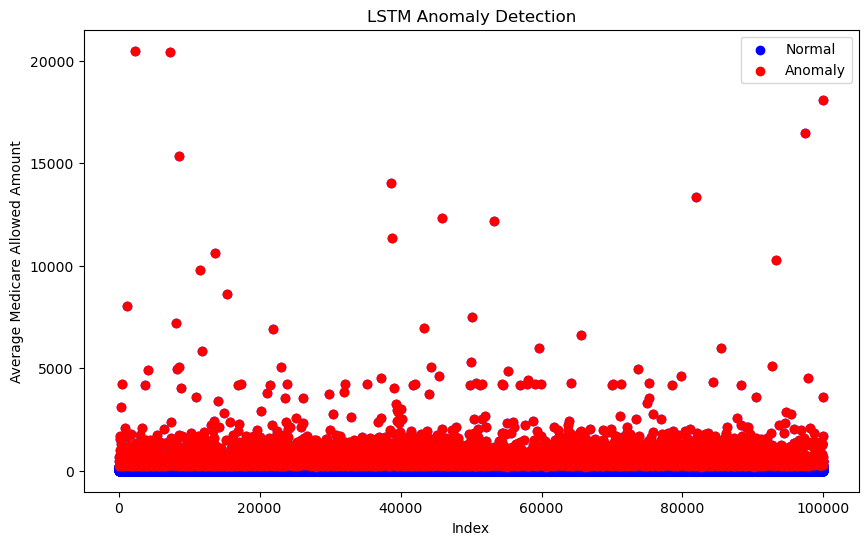

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('Healthcare Providers.csv')
df = pd.DataFrame(data)

# Remove commas, convert columns to numeric
df['Number of Medicare Beneficiaries'] = pd.to_numeric(df['Number of Medicare Beneficiaries'].str.replace(',', ''), errors='coerce')
df['Average Medicare Allowed Amount'] = pd.to_numeric(df['Average Medicare Allowed Amount'].str.replace(',', ''), errors='coerce')
df['Average Medicare Payment Amount'] = pd.to_numeric(df['Average Medicare Payment Amount'].str.replace(',', ''), errors='coerce')

# Remove rows with NaN values in key columns
df = df.dropna(subset=['Number of Medicare Beneficiaries', 'Average Medicare Allowed Amount', 'Average Medicare Payment Amount'])
df = df[df['Number of Medicare Beneficiaries'] > 0]

# Select features and scale
features = ['Average Medicare Allowed Amount', 'Average Medicare Payment Amount']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Set up sequences for LSTM model
sequence_length = 30  # Define the length of sequences (adjustable based on data)
X, y = [], []

for i in range(sequence_length, len(scaled_features)):
    X.append(scaled_features[i-sequence_length:i])  # Previous 30 samples as input
    y.append(scaled_features[i])  # Target is the next sample in sequence

X, y = np.array(X), np.array(y)

# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(X.shape[2])  # Output layer with same dimension as the number of features
])

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=5, batch_size=32, validation_split=0.2)

# Make predictions
y_pred = model.predict(X)

# Calculate reconstruction error
mse = np.mean(np.power(y - y_pred, 2), axis=1)
threshold = np.percentile(mse, 95)  # Set threshold as 95th percentile of errors
anomalies = mse > threshold

# Add anomaly column to original dataframe
df = df.iloc[sequence_length:]  # Shift df to align with X and y
df['Anomaly'] = anomalies

# Print anomaly summary
print(f'Number of anomalies detected: {sum(anomalies)}')

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Average Medicare Allowed Amount'], color='blue', label='Normal')
plt.scatter(df.index[anomalies], df['Average Medicare Allowed Amount'][anomalies], color='red', label='Anomaly')
plt.xlabel('Index')
plt.ylabel('Average Medicare Allowed Amount')
plt.title('LSTM Anomaly Detection')
plt.legend()
plt.show()